Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import string
from wordcloud import WordCloud
import warnings
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import f1_score, log_loss, multilabel_confusion_matrix, plot_confusion_matrix
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Import Library

In [ ]:
df = pd.read_csv("/content/Train.csv")
df.head()

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"


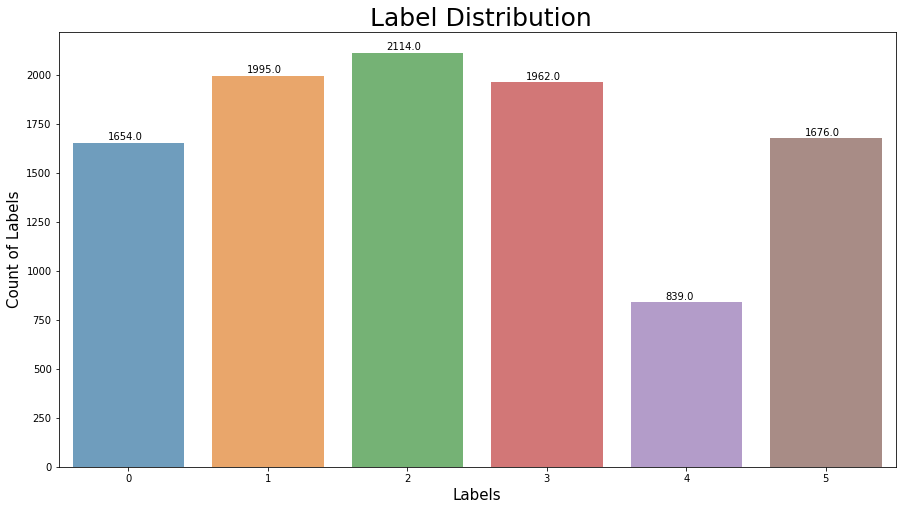

In [ ]:
plt.figure(figsize = (15,8))
graph = sns.countplot(data = df, x="Labels", alpha=0.7)
for p in graph.patches:
    graph.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+15))
plt.title(" Label Distribution",fontsize=25)
plt.ylabel('Count of Labels', fontsize=15)
plt.xlabel('Labels', fontsize=15)
plt.show()


Text Preprocessing

Remove Stopwords and word with length greater than 2

In [ ]:
from nltk.corpus import stopwords

df['Text'] = df['Text'].str.lower()
stop_words = set(stopwords.words('english'))

df['new_text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words) and len(word) > 2]))
print('With Stopwords: ')
print(df['Text'][1])
print('\n')
print('Without Stopwords: ')
print(df['new_text'][1])

With Stopwords: 
when did the decline of coal start? it started when natural gas took off that started to begin in (president george w.) bushs administration.


Without Stopwords: 
decline coal start? started natural gas took started begin (president george w.) bushs administration.


Removing Punctuations

In [ ]:
punctuations = list(string.punctuation)

df['clean_text'] = df['new_text'].str.replace('[^\w\s]','')
print('With Punctuation: ')
print(df['new_text'][1])
print('\n')
print('Without Punctuation: ')
print(df['clean_text'][1])

With Punctuation: 
decline coal start? started natural gas took started begin (president george w.) bushs administration.


Without Punctuation: 
decline coal start started natural gas took started begin president george w bushs administration


Word Cloud for label 1 (False News)

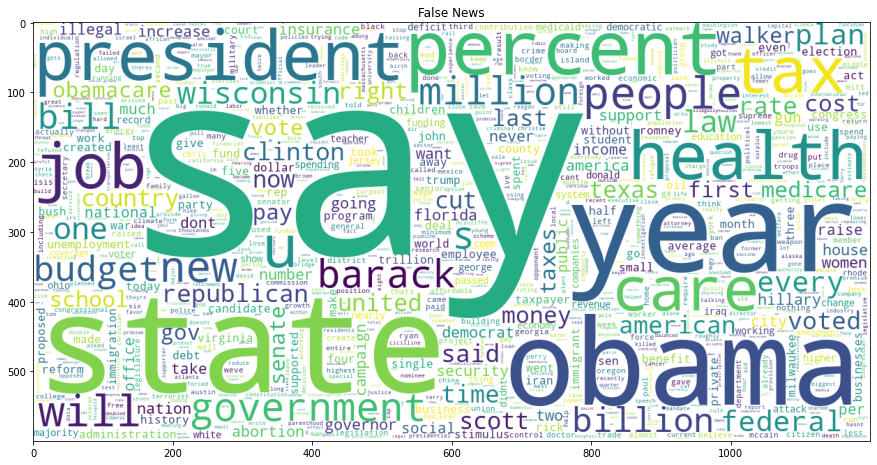

In [ ]:
wc = WordCloud(background_color='white', max_words = 1000 , width = 1200 , height = 600, 
               collocations=False).generate(" ".join(df[df['Labels']==1]['clean_text']))
plt.figure(figsize = (15,15))
plt.title("False News")
plt.imshow(wc)

Data Preparation

In [ ]:
num_classes = (df['Labels'].nunique())

In [ ]:
X = df['clean_text']
y = tf.keras.utils.to_categorical(df['Labels'], num_classes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
train_tokenizer.fit_on_texts(X_train.values)
train_word_index = train_tokenizer.word_index

In [ ]:
train_tokenizer

In [ ]:
vocab_length = len(train_word_index) + 1
vocab_length

11959

In [ ]:
train_sequences = train_tokenizer.texts_to_sequences(X_train)
len(train_sequences)

8192

In [ ]:
test_sequences = train_tokenizer.texts_to_sequences(X_test)
len(test_sequences)

2048

In [ ]:
maxlen=20
train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=maxlen, truncating='post')
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=maxlen, truncating='post')

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 28.1 MB/s 


RNN

In [ ]:
embedding_dim = 6
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=maxlen),
    tf.keras.layers.SimpleRNN(64, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(32, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(16, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=tfa.metrics.F1Score(num_classes=num_classes))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 6)             71754     
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 64)            4544      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 32)            3104      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 16)                784       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 6)                 1

In [ ]:
history = model.fit(train_padded_seqeunces, y_train, epochs=20, validation_data=(test_padded_seqeunces, y_test))


Epoch 1/20
256/256 [==============================] - 12s 25ms/step - loss: 1.7800 - f1_score: 0.1383 - val_loss: 1.7598 - val_f1_score: 0.0997
Epoch 2/20
256/256 [==============================] - 4s 17ms/step - loss: 1.7457 - f1_score: 0.1722 - val_loss: 1.7734 - val_f1_score: 0.1448
Epoch 3/20
256/256 [==============================] - 4s 16ms/step - loss: 1.6388 - f1_score: 0.2687 - val_loss: 1.8561 - val_f1_score: 0.1603
Epoch 4/20
256/256 [==============================] - 4s 16ms/step - loss: 1.4025 - f1_score: 0.4044 - val_loss: 2.0278 - val_f1_score: 0.1786
Epoch 5/20
256/256 [==============================] - 4s 16ms/step - loss: 1.1237 - f1_score: 0.5445 - val_loss: 2.4217 - val_f1_score: 0.1733
Epoch 6/20
256/256 [==============================] - 4s 15ms/step - loss: 0.8916 - f1_score: 0.6499 - val_loss: 2.6495 - val_f1_score: 0.1803
Epoch 7/20
256/256 [==============================] - 6s 25ms/step - loss: 0.6938 - f1_score: 0.7475 - val_loss: 3.0478 - val_f1_score: 0.180

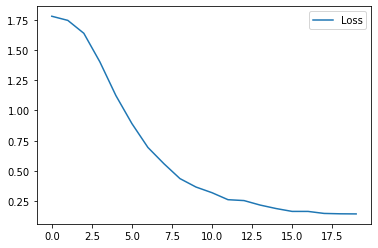

In [ ]:
plt.plot(history.history['loss'], label='Loss')

plt.legend()
plt.show()


Model Evaluation

In [ ]:
model.evaluate(test_padded_seqeunces, y_test)

64/64 [==============================] - 0s 5ms/step - loss: 5.1836 - f1_score: 0.1847


[5.183593273162842,
 array([0.15106732, 0.23665893, 0.19974059, 0.2235157 , 0.11295681,
        0.18443805], dtype=float32)]

In [ ]:
test_prob = model.predict(test_padded_seqeunces)
test_pred = np.where(test_prob > 0.5, 1, 0)

64/64 [==============================] - 1s 5ms/step


In [ ]:
from sklearn.metrics import f1_score, log_loss, multilabel_confusion_matrix, plot_confusion_matrix

In [ ]:
print("Log-Loss =", log_loss(y_test, test_prob))

Log-Loss = 5.1835931742892996


In [ ]:
print("F1-Score =", f1_score(y_test, test_pred, average = 'weighted'))

F1-Score = 0.19048450064349737


In [ ]:
labels = ['Barely-True', 'False', 'Half-True', 'Mostly-True', 'Not-Known', 'True']
cm = multilabel_confusion_matrix(y_test, test_pred)

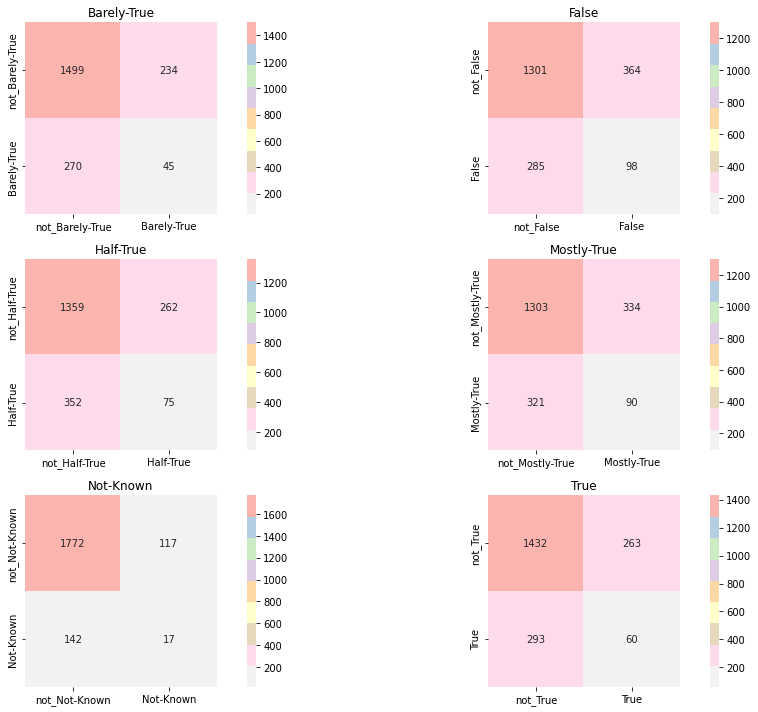

In [ ]:
fig = plt.figure(figsize = (15, 10))
for i, (label, matrix) in enumerate(zip(labels, cm)):
    plt.subplot(3, 2, i+1)
    l = [f'not_{label}', label]
    sns.heatmap(matrix, annot = True, square = True, xticklabels = l, yticklabels = l, cmap='Pastel1_r', fmt='d')
    plt.title(label)
    
plt.tight_layout()
plt.show()
